## Uncertainty quantification and spatial prediction
### *(General flow structure, NOT FINISHED)*

In [75]:
# EXTERNAL DEPENDENCIES

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.linalg import cholesky
from scipy.stats import norm
from scipy.spatial import distance_matrix
from scipy.optimize import curve_fit
from skgstat import Variogram

##### <ins>Step 1</ins>: Generate 2D Seismic Section Representing a Salt Dome

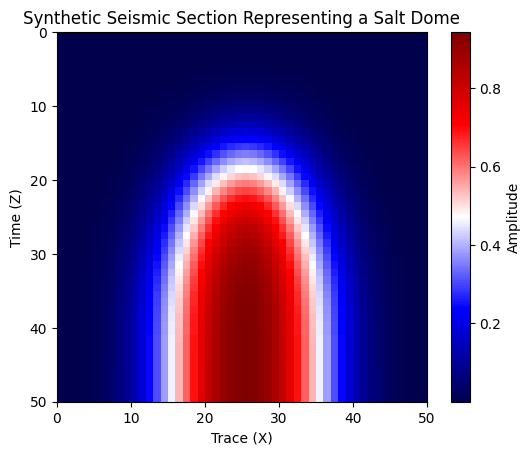

In [62]:
# 2D grid for seismic section
n_rows, n_cols = 50, 50
seismic_data = np.zeros((n_rows, n_cols))

# Salt dome parameters
#dome_center = (n_rows // 2, n_cols // 2)
#dome_radius = 10
## Salt dome, circular region
#for i in range(n_rows):
#    for j in range(n_cols):
#        distance = np.sqrt((i - dome_center[0])**2 + (j - dome_center[1])**2)
#        if distance < dome_radius:
#            seismic_data[i, j] = 1.0  # Salt dome value

## Salt dome, circular region
dome_center = (45, 25)  # Center of the dome (row, column)
dome_width = 10          # Width of the dome (horizontal extent)
dome_depth = 30          # Depth to which the dome extends
# Create the salt dome using a parabolic shape
for i in range(n_rows):
    for j in range(n_cols):
        # Calculate the distance from the dome center
        distance = np.sqrt(((i - dome_center[0]) / dome_depth) ** 2 + ((j - dome_center[1]) / dome_width) ** 2)
        # Define a parabolic shape for the dome
        if distance < 1:  # Only consider points within the dome boundary
            # Assign a value based on the distance to create a dome effect
            seismic_data[i, j] = 1.0 #* (1 - distance)  # Tapering effect


# Smoothing, to represent realistic seismic reflection
seismic_data = gaussian_filter(seismic_data, sigma=5)

# Plot
plt.imshow(seismic_data, cmap='seismic', extent=[0, n_cols, n_rows, 0])
plt.colorbar(label='Amplitude')
plt.title('Synthetic Seismic Section Representing a Salt Dome')
plt.xlabel('Trace (X)')
plt.ylabel('Time (Z)')
plt.show()


##### <ins>Step 2</ins>: Apply Gaussian Process Regression for Uncertainty Quantification

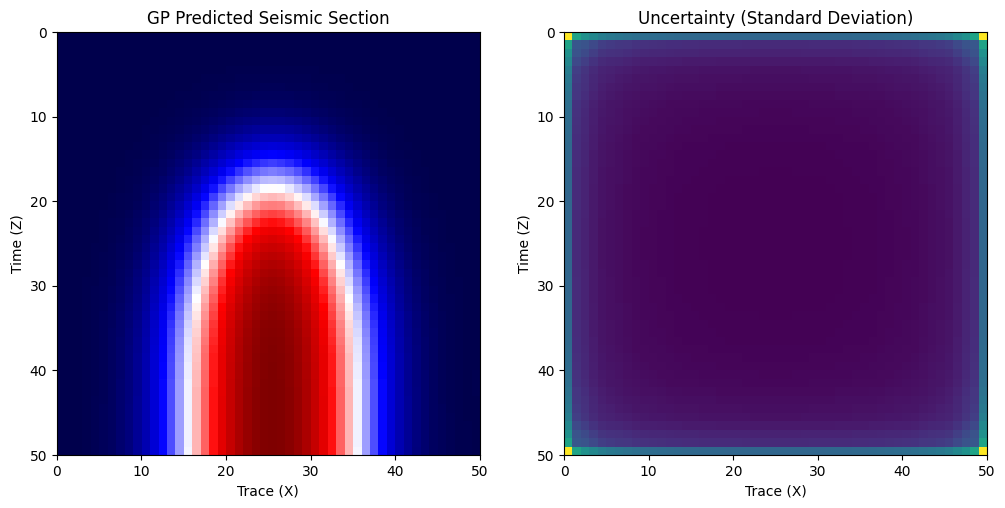

In [6]:
# Grid of points (features) for the Gaussian Process
#X = np.array([(i, j) for i in range(n_rows) for j in range(n_cols)])
X = []
for i in range(n_rows):
    for j in range(n_cols):
        X.append((i, j))
X = np.array(X)
y = seismic_data.ravel()

# Gaussian Process with RBF kernel
kernel = RBF(length_scale=10)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-5)

# GP model fit on seismic data
gp.fit(X, y)

# Prediction of values and uncertainties
y_pred, sigma = gp.predict(X, return_std=True)

# Reshape
y_pred_grid = y_pred.reshape(n_rows, n_cols)
sigma_grid = sigma.reshape(n_rows, n_cols)

# Plots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Seismic section prediction
ax[0].imshow(y_pred_grid, cmap='seismic', extent=[0, n_cols, n_rows, 0])
ax[0].set_title('GP Predicted Seismic Section')
ax[0].set_xlabel('Trace (X)')
ax[0].set_ylabel('Time (Z)')

# Uncertainty
ax[1].imshow(sigma_grid, cmap='viridis', extent=[0, n_cols, n_rows, 0])
ax[1].set_title('Uncertainty (Standard Deviation)')
ax[1].set_xlabel('Trace (X)')
ax[1].set_ylabel('Time (Z)')

plt.show()


##### <ins>Step 3</ins>: Apply Sequential Gaussian Simulation Using Covariance Matrix

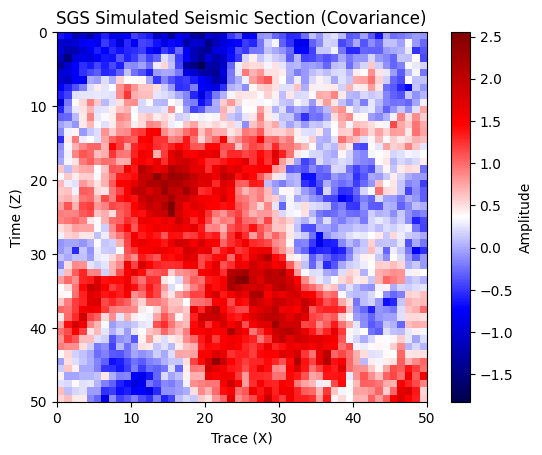

In [17]:
# Exponential covariance matrix
def exponential_covariance(h, range_param, sill):
    return sill * np.exp(-h / range_param)

# Covariance parameters
range_param = 20
sill = 1.0

# Covariance matrix for all points in the grid
covariance_matrix = np.zeros((n_rows * n_cols, n_rows * n_cols))
for i in range(n_rows * n_cols):
    for j in range(n_rows * n_cols):
        x1, y1 = X[i]
        x2, y2 = X[j]
        distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
        covariance_matrix[i, j] = exponential_covariance(distance, range_param, sill)

# Cholesky decomposition to generate realizations
L = cholesky(covariance_matrix, lower=True)
random_samples = norm.rvs(size=(n_rows * n_cols))
simulated_values = L @ random_samples

# Reshape
simulated_section = simulated_values.reshape(n_rows, n_cols)

# Plot
plt.imshow(simulated_section, cmap='seismic', extent=[0, n_cols, n_rows, 0])
plt.colorbar(label='Amplitude')
plt.title('SGS Simulated Seismic Section (Covariance)')
plt.xlabel('Trace (X)')
plt.ylabel('Time (Z)')
plt.show()


##### <ins>Step 4</ins>: Apply Sequential Gaussian Simulation Using a Variogram

d:\Apps\Anaconda3\envs\gempy3\lib\site-packages\skgstat\plotting\variogram_plot.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


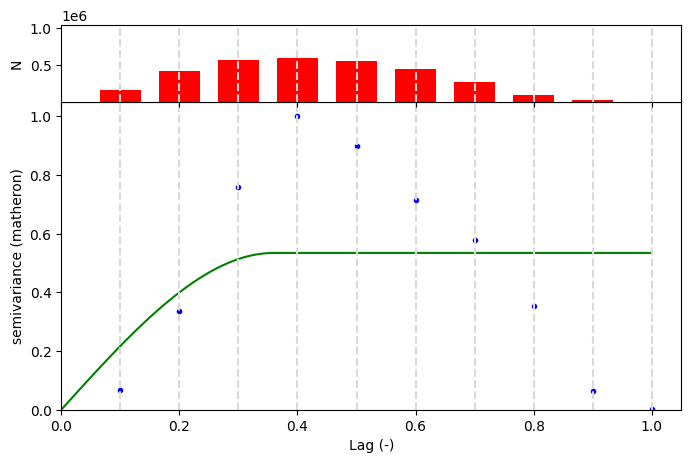

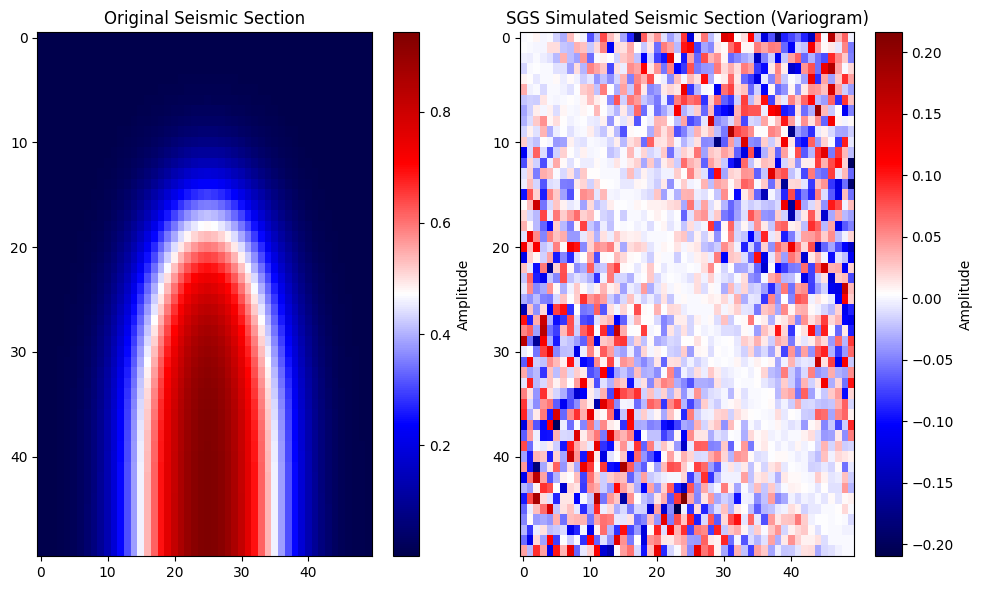

In [80]:
#################
# SKGSTAT LIBRARY
#################

# Noise in the seismic section, for variability
#seismic_data += np.random.normal(0, 0.5, seismic_data.shape)

coords = []
for i in range(n_rows):
    for j in range(n_cols):
        coords.append((i, j))
coords = np.array(coords)
values = seismic_data.ravel()

# Distance matrix
distances = np.zeros((n_rows, n_cols))
for i in range(n_rows):
        for j in range(n_cols):
            # Distance between points
            distance = np.sqrt((coords[i, 0] - coords[j, 0])**2 + (coords[i, 1] - coords[j, 1])**2)
            distances[i, j] = distance


# SKGSTAT variogram, Variogram object with Euclidean distance
variogram = Variogram(coords, values, model='spherical', dist_func='euclidean', bin_func='even', normalize=True)
# Variogram plot
variogram.plot()

# SKGSTAT - Sequential Gaussian simulation with SKGSTAT variogram model
def sgs_with_variogram(variogram, n_rows, n_cols):
    simulated_grid = np.zeros((n_rows, n_cols))
    # Distance matrix and variogram model values
    for i in range(n_rows):
        for j in range(n_cols):
            # Distance between points
            distance = np.sqrt((coords[i, 0] - coords[j, 0])**2 + (coords[i, 1] - coords[j, 1])**2)            
            # Simulate value using variogram model at the given distance
            sim_value = np.random.normal(0, variogram.transform([distance])[0])
            simulated_grid[i, j] = sim_value
    return simulated_grid

# SKGSTAT: Simulated section with SKGSTAT variogram
simulated_section_with_variogram = sgs_with_variogram(variogram, n_rows, n_cols)


# Plots
plt.figure(figsize=(10, 6))

# Original seismic section
plt.subplot(1, 2, 1)
plt.imshow(seismic_data, cmap='seismic', aspect='auto')
plt.colorbar(label='Amplitude')
plt.title('Original Seismic Section')

# Simulated seismic section (variogram-based)
plt.subplot(1, 2, 2)
plt.imshow(simulated_section_with_variogram, cmap='seismic', aspect='auto')
plt.colorbar(label='Amplitude')
plt.title('SGS Simulated Seismic Section (Variogram)')
plt.tight_layout()
plt.show()


C:\Users\cco\AppData\Local\Temp\ipykernel_35592\2689299398.py:98: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  simulated_values[idx] = simulated_value
C:\Users\cco\AppData\Local\Temp\ipykernel_35592\2689299398.py:99: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  uncertainty_values[idx] = variance


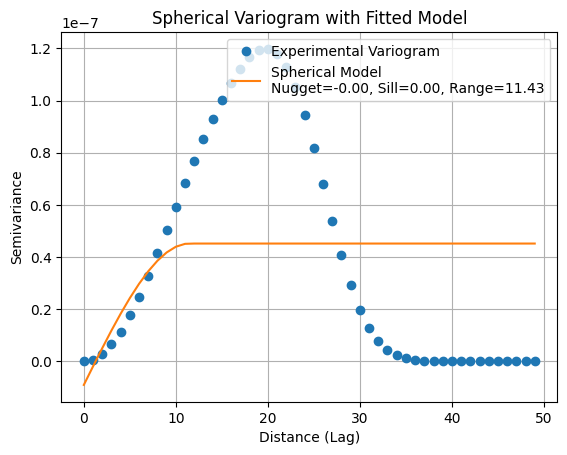

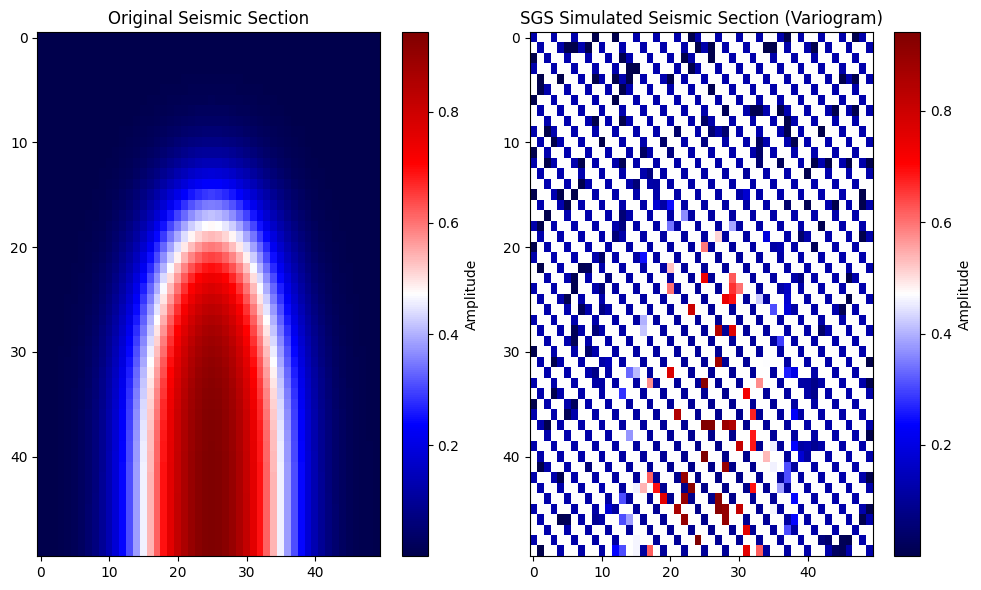

In [79]:
####################
# MANUAL COMPUTATION
####################

# Variogram computation
def compute_variogram(data, distances, lag_step=1, max_lag=50):
    lags = np.arange(0, max_lag, lag_step)
    variogram = np.zeros_like(lags, dtype=float)

    for i, lag in enumerate(lags):
        # Find all point pairs within a certain lag range
        mask = (distances >= lag) & (distances < lag + lag_step)
        point_pairs = np.argwhere(mask)
        
        if point_pairs.size > 0:
            differences = data[point_pairs[:, 0]] - data[point_pairs[:, 1]]
            variogram[i] = np.mean(differences**2) / 2
        else:
            variogram[i] = np.nan

    return lags, variogram


# Spherical variogram model
def spherical_model(h, nugget, sill, range_):
    return np.where(h <= range_,
                    nugget + (sill - nugget) * (1.5 * (h / range_) - 0.5 * (h / range_)**3),
                    sill)


# Sequential Gaussian Simulation
def sequential_gaussian_simulation(sgs_grid_points, spherical_model, nugget, sill, range_, n_simulations=5, reg_factor=1e-5):
    for sim in range(n_simulations):
        for idx in range(0, len(sgs_grid_points), 3):
            # If current point is already known, skip it
            if not np.isnan(simulated_values[idx]):
                continue

            # Combine previously simulated and known points
            known_indices = np.where(~np.isnan(simulated_values))[0]  # Get indices of known and already simulated points
            current_point = sgs_grid_points[idx]

            # Check if there are simulated points, skip otherwise
            if len(known_indices) == 0:
                simulated_values[idx] = np.random.normal(0, np.sqrt(sill))
                uncertainty_values[idx] = sill
                continue

            # Computations of distances
            dist_matrix = distance_matrix([current_point], sgs_grid_points[known_indices])
            known_dist_matrix = distance_matrix(sgs_grid_points[known_indices], sgs_grid_points[known_indices])

            # Covariance matrices
            cov_known = spherical_model(known_dist_matrix, nugget, sill, range_)
            cov_grid_known = spherical_model(dist_matrix, nugget, sill, range_)

            # Regularization (nugget effect to diagonal to avoid singular matrix)
            cov_known += np.eye(cov_known.shape[0]) * reg_factor

            try:
                # Kriging system solution: λ * cov_known = cov_grid_known
                weights = np.linalg.solve(cov_known, cov_grid_known.T)

                # Prediction of new value
                mean = weights.T @ simulated_values[known_indices]
                variance = np.maximum(sill - np.einsum('ij,ij->i', weights.T, cov_grid_known), 0)  # Ensure non-negative variance
                simulated_value = np.random.normal(mean, np.sqrt(variance))
                simulated_values[idx] = simulated_value
                uncertainty_values[idx] = variance

            except np.linalg.LinAlgError:
                print(f"Singular matrix encountered at point {idx}, simulation {sim}. Using fallback.")
                simulated_values[idx] = np.random.normal(0, np.sqrt(sill))
                uncertainty_values[idx] = sill

    return simulated_values, uncertainty_values


# Experimental variogram with geodesic distances
lags, experimental_variogram = compute_variogram(values, distances)

# Model fit to experimental variogram
initial_params = [0.1, 1, 10]  # Initial guess for nugget, sill, range
valid = ~np.isnan(experimental_variogram)  # Remove NaN values for fitting
var_parameters, _ = curve_fit(spherical_model, lags[valid], experimental_variogram[valid], p0=initial_params)

# Fitted variogram curve
fitted_variogram = spherical_model(lags, *var_parameters)

#nugget, sill, range_ = var_parameters
nugget, sill, range_ = var_parameters
#nugget, sill, range_ = 0.0, 0.01, 3.57

# Grid for SGS prediction, in this case smaller than input to reduce computer resources
n_rows_sgs_grid, n_cols_sgs_grid = 50, 50
sgs_grid_points = []
for i in range(n_rows_sgs_grid):
    for j in range(n_cols_sgs_grid):
        sgs_grid_points.append((i, j))
sgs_grid_points = np.array(sgs_grid_points)

# Initializations of arrays
simulated_values = np.full(n_rows_sgs_grid * n_cols_sgs_grid, np.nan)  # Start with NaNs
uncertainty_values = np.full(n_rows_sgs_grid * n_cols_sgs_grid, np.nan)  # Initialize uncertainty array

# Know points (in this case from input data)
known_data_mask = np.random.rand(n_rows_sgs_grid, n_cols_sgs_grid) < 0.1  # Randomly select 10% as known
known_indices = np.where(known_data_mask.ravel())[0]
simulated_values[known_indices] = seismic_data.ravel()[known_indices]


# Simulation
simulated_section_with_variogram, uncertainty_values = sequential_gaussian_simulation(sgs_grid_points, spherical_model, nugget, sill, range_)
# Reshape
simulated_section_with_variogram = simulated_section_with_variogram.reshape(n_rows_sgs_grid, n_cols_sgs_grid)
uncertainty_values_2d = uncertainty_values.reshape(n_rows_sgs_grid, n_cols_sgs_grid)
# Variogram plot
plt.plot(lags, experimental_variogram, 'o', label='Experimental Variogram')
plt.plot(lags, fitted_variogram, '-', label=f'Spherical Model\nNugget={var_parameters[0]:.2f}, Sill={var_parameters[1]:.2f}, Range={var_parameters[2]:.2f}')
plt.title('Spherical Variogram with Fitted Model')
plt.xlabel('Distance (Lag)')
plt.ylabel('Semivariance')
plt.legend()
plt.grid()
plt.show()


# Plots
plt.figure(figsize=(10, 6))

# Original seismic section
plt.subplot(1, 2, 1)
plt.imshow(seismic_data, cmap='seismic', aspect='auto')
plt.colorbar(label='Amplitude')
plt.title('Original Seismic Section')

# Simulated seismic section (variogram-based)
plt.subplot(1, 2, 2)
plt.imshow(simulated_section_with_variogram, cmap='seismic', aspect='auto')
plt.colorbar(label='Amplitude')
plt.title('SGS Simulated Seismic Section (Variogram)')
plt.tight_layout()
plt.show()

##### Notes

Gaussian Process Regression produces smooth predictions with uncertainty estimates based on a covariance kernel.<br>
SGS with Covariance Matrix produces random realizations based on a predefined covariance structure, allowing for uncertainty quantification.<br>
SGS with Variogram models the spatial relationship between points, incorporating local structure into the simulations.